# 论文26：CS231n - 视觉识别的卷积神经网络

**课程**：斯坦福CS231n（2017春季）- Fei-Fei Li、Justin Johnson、Serena Yeung

**视觉圣经**：CS231n是深度学习用于计算机视觉的权威课程。本笔记本将其核心概念提炼为单个可执行实现，仅使用NumPy。

---

## CS231n是什么？

CS231n教授视觉识别的基础：
- 图像分类流程（从像素到预测）
- 反向传播和优化
- 卷积神经网络
- 现代架构（AlexNet、VGG、ResNet）
- 训练技术和"看护"神经网络

## 本实现

我们将从零开始构建完整的视觉流程：

1. **k近邻**：基线分类器
2. **线性分类器**：SVM和Softmax
3. **优化**：SGD、动量、学习率调度
4. **神经网络**：2层全连接网络
5. **反向传播**：手动梯度计算
6. **卷积网络**：Conv、pool、ReLU层
7. **架构**：AlexNet风格的CNN、VGG、ResNet概念
8. **可视化**：显著性图、滤波器可视化

## 为什么这很重要

**CS231n原则适用于所有地方**：
- AlexNet (2012) → ImageNet突破
- VGG/ResNet → 标准视觉骨干
- 这里的技术 → 现代transformer、扩散模型

**与论文#7的联系**：这为AlexNet提供了教学基础！

让我们从第一原则构建视觉系统！

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from typing import Tuple, List, Dict
from dataclasses import dataclass

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

plt.style.use('seaborn-v0_8-darkgrid')

print("CS231n: 从像素到预测")
print("NumPy 版本:", np.__version__)
print("\n准备学习计算机视觉！")

CS231n: 从像素到预测
NumPy 版本: 2.4.1

准备学习计算机视觉！


# 第1节：数据集 - 合成CIFAR-10

CS231n使用CIFAR-10（10个类别，32×32 RGB图像）。我们将生成具有类似结构的合成数据。

## 数据生成策略

创建具有类别特定模式的程序化32×32图像：
- **类别0-2**：螺旋线（不同旋转）
- **类别3-5**：棋盘（不同频率）
- **类别6-7**：渐变（不同方向）
- **类别8-9**：圆形（不同大小）

这为我们提供了：
- 可学习的模式（非纯噪声）
- 视觉多样性（测试不同特征）
- 即时生成（无需下载）

生成合成 CIFAR-10 数据集...

训练集:   X=(2000, 32, 32, 3), y=(2000,)
验证集:   X=(400, 32, 32, 3), y=(400,)
测试集:   X=(400, 32, 32, 3), y=(400,)


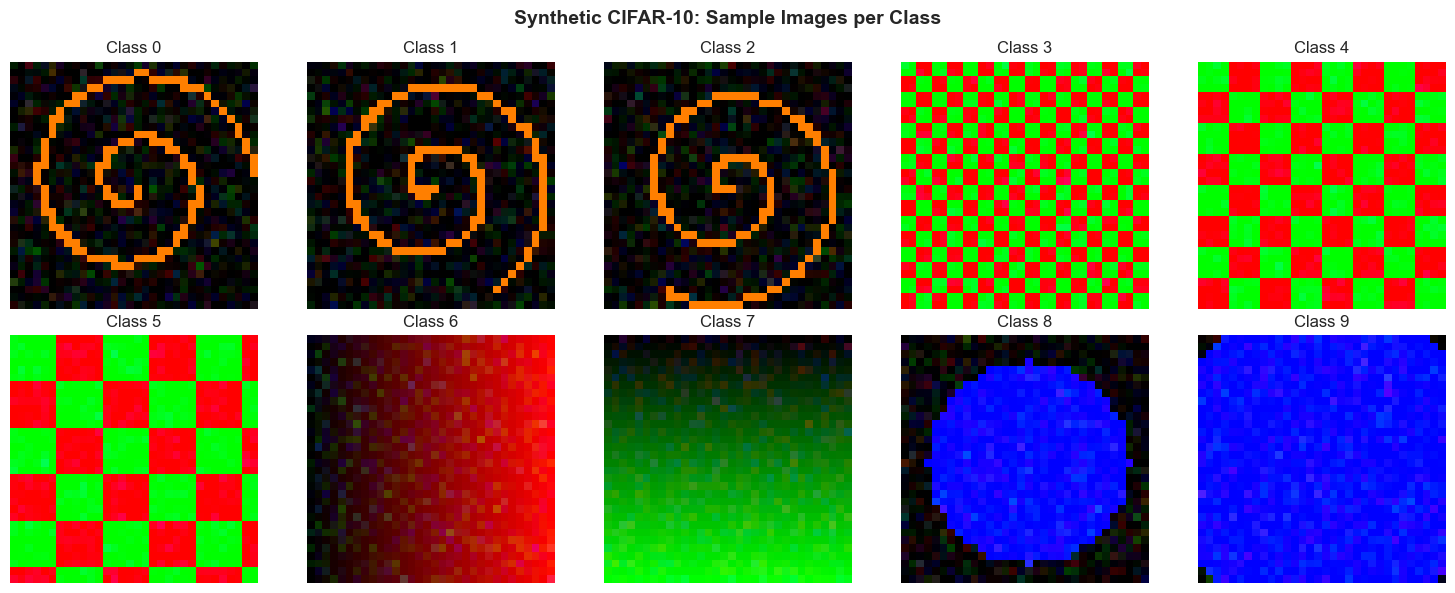


展平后形状: (2000, 3072) (32×32×3 = 3072 像素)

✓ 数据集准备完成！


In [2]:
def generate_synthetic_cifar(num_samples: int = 1000, 
                             img_size: int = 32, 
                             num_classes: int = 10) -> Tuple[np.ndarray, np.ndarray]:
    """Generate synthetic CIFAR-10 style dataset.
    
    Returns:
        X: (N, 32, 32, 3) RGB images
        y: (N,) class labels
    """
    X = np.zeros((num_samples, img_size, img_size, 3))
    y = np.random.randint(0, num_classes, num_samples)
    
    for i in range(num_samples):
        label = y[i]
        img = np.random.randn(img_size, img_size, 3) * 0.1  # Base noise
        
        # Class-specific patterns
        if label < 3:  # Spirals
            theta = np.linspace(0, 4*np.pi, 200)
            r = np.linspace(0, img_size/2, 200)
            rotation = label * np.pi / 3
            x_coords = (r * np.cos(theta + rotation) + img_size/2).astype(int)
            y_coords = (r * np.sin(theta + rotation) + img_size/2).astype(int)
            valid = (x_coords >= 0) & (x_coords < img_size) & (y_coords >= 0) & (y_coords < img_size)
            img[y_coords[valid], x_coords[valid], :] = [1.0, 0.5, 0.0]
            
        elif label < 6:  # Checkerboards
            freq = (label - 2) * 2
            xx, yy = np.meshgrid(np.arange(img_size), np.arange(img_size))
            pattern = ((xx // freq) + (yy // freq)) % 2
            img[:, :, 0] = pattern
            img[:, :, 1] = 1 - pattern
            
        elif label < 8:  # Gradients
            if label == 6:
                img[:, :, 0] = np.linspace(0, 1, img_size)[None, :]
            else:
                img[:, :, 1] = np.linspace(0, 1, img_size)[:, None]
                
        else:  # Circles
            radius = (label - 7) * 8 + 5
            yy, xx = np.ogrid[:img_size, :img_size]
            circle = ((xx - img_size/2)**2 + (yy - img_size/2)**2 <= radius**2)
            img[circle, 2] = 1.0
        
        X[i] = np.clip(img, 0, 1)
    
    return X, y


# Generate train/val/test splits
print("生成合成 CIFAR-10 数据集...\n")

X_train, y_train = generate_synthetic_cifar(num_samples=2000)
X_val, y_val = generate_synthetic_cifar(num_samples=400)
X_test, y_test = generate_synthetic_cifar(num_samples=400)

print(f"训练集:   X={X_train.shape}, y={y_train.shape}")
print(f"验证集:   X={X_val.shape}, y={y_val.shape}")
print(f"测试集:   X={X_test.shape}, y={y_test.shape}")

# Visualize samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    idx = np.where(y_train == i)[0][0]
    ax.imshow(X_train[idx])
    ax.set_title(f'Class {i}')
    ax.axis('off')

plt.suptitle('Synthetic CIFAR-10: Sample Images per Class', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Flatten for traditional classifiers
X_train_flat = X_train.reshape(len(X_train), -1)  # (N, 3072)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

print(f"\n展平后形状: {X_train_flat.shape} (32×32×3 = 3072 像素)")
print("\n✓ 数据集准备完成！")

# 第2节：k近邻（kNN）

**最简单的分类器**：给定测试图像，找到k个最近的训练图像并对标签进行投票。

## 算法

1. 计算到所有训练图像的距离：$d(x_{\text{test}}, x_{\text{train}})$
2. 找到k个最近的邻居
3. 对它们的标签进行多数投票

## 距离度量

**L1（曼哈顿）**：
$$d_1(x, y) = \sum_i |x_i - y_i|$$

**L2（欧几里得）**：
$$d_2(x, y) = \sqrt{\sum_i (x_i - y_i)^2}$$

## 为什么kNN很重要

- **无训练**：只记忆数据
- **测试时慢**：每次预测O(N)
- **基线**：建立下界
- **实践中从不使用**：但在教学上很重要！

测试 k-Nearest Neighbors...

kNN '训练'完成，使用 2000 个样本

测试不同的 k 值...
  k= 1: L1=100.0%, L2=100.0%
  k= 3: L1=100.0%, L2=100.0%
  k= 5: L1=100.0%, L2=100.0%
  k=10: L1=100.0%, L2=100.0%
  k=20: L1=100.0%, L2=100.0%


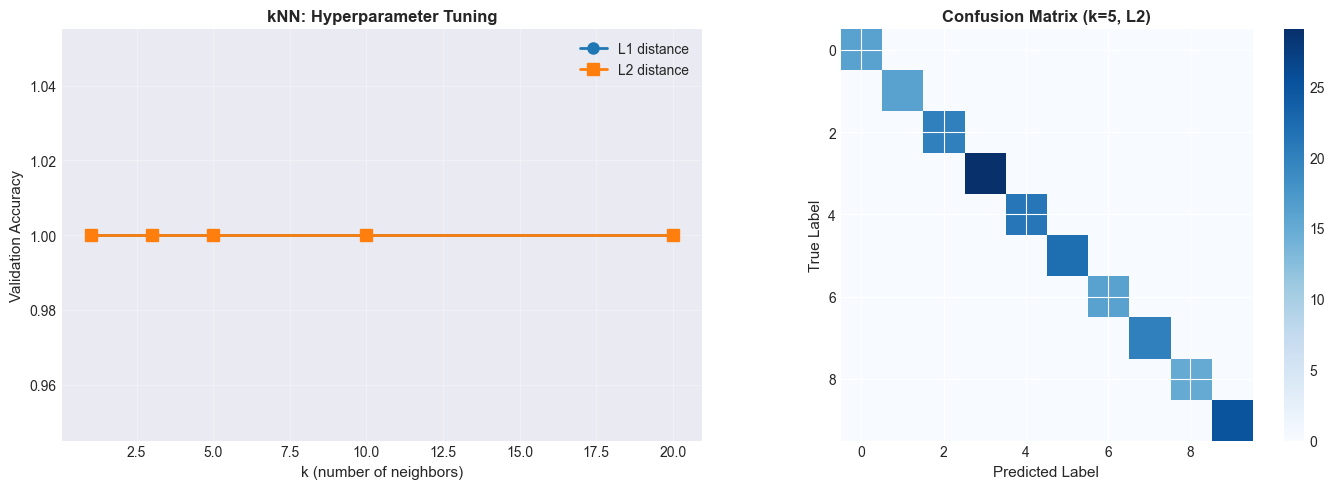


🔑 关键见解:
   • kNN: 无需训练，但测试时很慢
   • k=1: 过拟合（记忆噪声）
   • k 过大: 欠拟合（平均过度）
   • 最佳 k: 通过验证集找到
   • 最佳准确率: 100.0% (baseline!)

✓ kNN 完成！让我们用参数化模型做得更好...


In [3]:
class KNearestNeighbor:
    """k-Nearest Neighbor classifier."""
    
    def __init__(self, k: int = 5):
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def train(self, X: np.ndarray, y: np.ndarray):
        """'Train' by memorizing data (no actual training!)."""
        self.X_train = X
        self.y_train = y
        print(f"kNN '训练'完成，使用 {len(X)} 个样本")
    
    def predict(self, X: np.ndarray, distance_metric: str = 'l2') -> np.ndarray:
        """Predict labels for test data.
        
        Args:
            X: (N_test, D) test data
            distance_metric: 'l1' or 'l2'
        
        Returns:
            y_pred: (N_test,) predicted labels
        """
        num_test = X.shape[0]
        y_pred = np.zeros(num_test, dtype=int)
        
        for i in range(num_test):
            # Compute distances to all training samples
            if distance_metric == 'l1':
                distances = np.sum(np.abs(self.X_train - X[i]), axis=1)
            else:  # l2
                distances = np.sqrt(np.sum((self.X_train - X[i])**2, axis=1))
            
            # Find k nearest neighbors
            k_nearest = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_nearest]
            
            # Majority vote
            y_pred[i] = np.argmax(np.bincount(k_nearest_labels))
        
        return y_pred
    
    def compute_accuracy(self, X: np.ndarray, y: np.ndarray, **kwargs) -> float:
        """Compute classification accuracy."""
        y_pred = self.predict(X, **kwargs)
        return np.mean(y_pred == y)


# Train kNN (just memorize)
print("测试 k-Nearest Neighbors...\n")

knn = KNearestNeighbor(k=5)
knn.train(X_train_flat, y_train)

# Test different k values
k_values = [1, 3, 5, 10, 20]
accuracies_l1 = []
accuracies_l2 = []

print("\n测试不同的 k 值...")
for k in k_values:
    knn.k = k
    acc_l1 = knn.compute_accuracy(X_val_flat[:100], y_val[:100], distance_metric='l1')
    acc_l2 = knn.compute_accuracy(X_val_flat[:100], y_val[:100], distance_metric='l2')
    accuracies_l1.append(acc_l1)
    accuracies_l2.append(acc_l2)
    print(f"  k={k:2d}: L1={acc_l1:.1%}, L2={acc_l2:.1%}")

# Plot accuracy vs k
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy vs k
axes[0].plot(k_values, accuracies_l1, 'o-', linewidth=2, markersize=8, label='L1 distance')
axes[0].plot(k_values, accuracies_l2, 's-', linewidth=2, markersize=8, label='L2 distance')
axes[0].set_xlabel('k (number of neighbors)', fontsize=11)
axes[0].set_ylabel('Validation Accuracy', fontsize=11)
axes[0].set_title('kNN: Hyperparameter Tuning', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Confusion matrix for k=5
knn.k = 5
y_pred = knn.predict(X_val_flat[:200], distance_metric='l2')
y_true = y_val[:200]

confusion = np.zeros((10, 10))
for true, pred in zip(y_true, y_pred):
    confusion[true, pred] += 1

im = axes[1].imshow(confusion, cmap='Blues')
axes[1].set_xlabel('Predicted Label', fontsize=11)
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_title('Confusion Matrix (k=5, L2)', fontsize=12, fontweight='bold')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

print("\n🔑 关键见解:")
print("   • kNN: 无需训练，但测试时很慢")
print("   • k=1: 过拟合（记忆噪声）")
print("   • k 过大: 欠拟合（平均过度）")
print("   • 最佳 k: 通过验证集找到")
print(f"   • 最佳准确率: {max(max(accuracies_l1), max(accuracies_l2)):.1%} (baseline!)")
print("\n✓ kNN 完成！让我们用参数化模型做得更好...")

# 第3节：线性分类器 - SVM和Softmax

**参数化模型**：学习权重矩阵$W$来预测分数。

## 评分函数

$$f(x; W, b) = Wx + b$$

其中：
- $x \in \mathbb{R}^D$：输入图像（3072像素）
- $W \in \mathbb{R}^{C \times D}$：权重矩阵（10 × 3072）
- $b \in \mathbb{R}^C$：偏置向量（10,）
- 输出：$f \in \mathbb{R}^C$：类别分数（10,）

## 损失函数

### 1. 多类SVM损失（Hinge损失）

$$L = \frac{1}{N} \sum_{i=1}^N \sum_{j \neq y_i} \max(0, s_j - s_{y_i} + \Delta)$$

其中$\Delta = 1$是边界。

**直觉**：正确类分数应至少比错误类高$\Delta$。

### 2. Softmax损失（交叉熵）

$$L = -\frac{1}{N} \sum_{i=1}^N \log\left(\frac{e^{s_{y_i}}}{\sum_j e^{s_j}}\right)$$

**直觉**：最大化正确类的对数概率。

## 正则化

添加惩罚以防止过拟合：

$$L_{\text{total}} = L_{\text{data}} + \lambda R(W)$$

常见选择：
- **L2**：$R(W) = \sum_{i,j} W_{ij}^2$（权重衰减）
- **L1**：$R(W) = \sum_{i,j} |W_{ij}|$（稀疏性）

训练 Softmax 分类器...

迭代    0/1000: Loss=2.3031, 训练准确率=69.90%, 验证准确率=67.50%
迭代  100/1000: Loss=0.7432, 训练准确率=100.00%, 验证准确率=100.00%
迭代  200/1000: Loss=0.4103, 训练准确率=100.00%, 验证准确率=100.00%
迭代  300/1000: Loss=0.2674, 训练准确率=100.00%, 验证准确率=100.00%
迭代  400/1000: Loss=0.1840, 训练准确率=100.00%, 验证准确率=100.00%
迭代  500/1000: Loss=0.1298, 训练准确率=100.00%, 验证准确率=100.00%
迭代  600/1000: Loss=0.1123, 训练准确率=100.00%, 验证准确率=100.00%
迭代  700/1000: Loss=0.0823, 训练准确率=100.00%, 验证准确率=100.00%
迭代  800/1000: Loss=0.0776, 训练准确率=100.00%, 验证准确率=100.00%
迭代  900/1000: Loss=0.0594, 训练准确率=100.00%, 验证准确率=100.00%

训练 SVM 分类器...

迭代    0/1000: Loss=9.0111, 训练准确率=52.20%, 验证准确率=55.50%
迭代  100/1000: Loss=0.0000, 训练准确率=100.00%, 验证准确率=100.00%
迭代  200/1000: Loss=0.0000, 训练准确率=100.00%, 验证准确率=100.00%
迭代  300/1000: Loss=0.0000, 训练准确率=100.00%, 验证准确率=100.00%
迭代  400/1000: Loss=0.0000, 训练准确率=100.00%, 验证准确率=100.00%
迭代  500/1000: Loss=0.0000, 训练准确率=100.00%, 验证准确率=100.00%
迭代  600/1000: Loss=0.0000, 训练准确率=100.00%, 验证准确率=100.00%
迭代  700/1000: Los

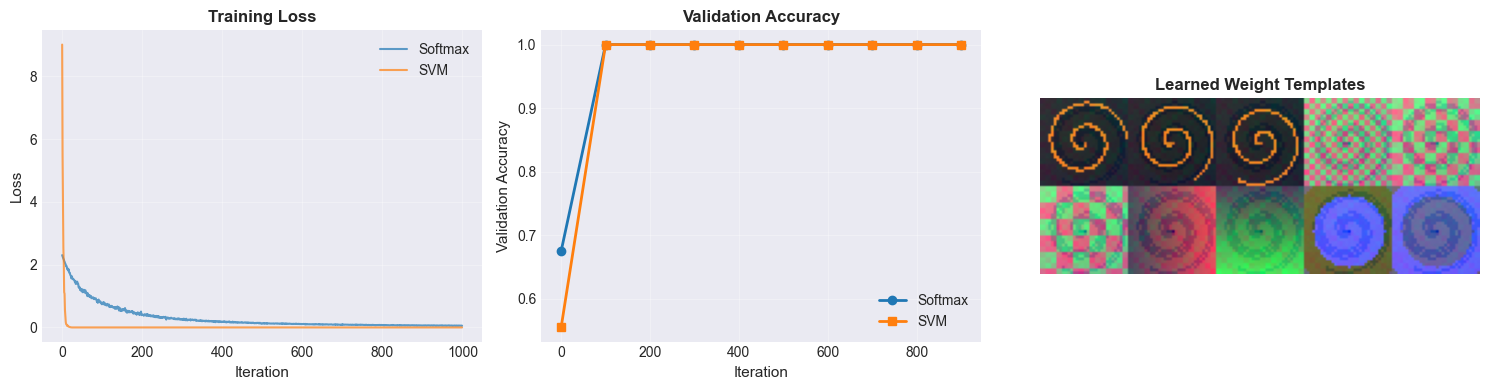


最终测试准确率:
  Softmax: 100.00%
  SVM:     100.00%
  kNN:     100.00% (baseline)

🔑 关键见解:
   • 线性分类器: f(x) = Wx + b（每个类别一个模板）
   • SVM: 基于间隔（hinge loss）
   • Softmax: 基于概率（交叉熵）
   • 两者都超过 kNN 且训练快速！
   • 权重看起来像平均的类别模板

✓ 线性分类器完成！让我们添加非线性...


In [4]:
class LinearClassifier:
    """Linear classifier with SVM or Softmax loss."""
    
    def __init__(self, input_dim: int = 3072, num_classes: int = 10):
        self.W = np.random.randn(input_dim, num_classes) * 0.0001
        self.b = np.zeros(num_classes)
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        """Compute class scores.
        
        Args:
            X: (N, D) input data
        
        Returns:
            scores: (N, C) class scores
        """
        return X @ self.W + self.b
    
    def svm_loss(self, X: np.ndarray, y: np.ndarray, reg: float = 1e-5) -> Tuple[float, np.ndarray, np.ndarray]:
        """Compute SVM loss and gradients.
        
        Returns:
            loss: Scalar loss
            dW: Gradient of loss w.r.t. W
            db: Gradient of loss w.r.t. b
        """
        N = X.shape[0]
        scores = self.forward(X)  # (N, C)
        
        # Compute margins
        correct_scores = scores[range(N), y].reshape(-1, 1)  # (N, 1)
        margins = np.maximum(0, scores - correct_scores + 1)  # (N, C)
        margins[range(N), y] = 0  # Don't count correct class
        
        # Loss
        loss = np.sum(margins) / N
        loss += reg * np.sum(self.W ** 2)  # L2 regularization
        
        # Gradients
        binary = (margins > 0).astype(float)  # (N, C)
        binary[range(N), y] = -np.sum(binary, axis=1)  # Correct class gets negative
        
        dW = (X.T @ binary) / N + 2 * reg * self.W
        db = np.sum(binary, axis=0) / N
        
        return loss, dW, db
    
    def softmax_loss(self, X: np.ndarray, y: np.ndarray, reg: float = 1e-5) -> Tuple[float, np.ndarray, np.ndarray]:
        """Compute Softmax loss and gradients.
        
        Returns:
            loss: Scalar loss
            dW: Gradient of loss w.r.t. W
            db: Gradient of loss w.r.t. b
        """
        N = X.shape[0]
        scores = self.forward(X)  # (N, C)
        
        # Numerical stability: shift scores
        scores -= np.max(scores, axis=1, keepdims=True)
        
        # Softmax probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)  # (N, C)
        
        # Loss
        correct_log_probs = -np.log(probs[range(N), y] + 1e-10)
        loss = np.sum(correct_log_probs) / N
        loss += reg * np.sum(self.W ** 2)
        
        # Gradients
        dscores = probs.copy()
        dscores[range(N), y] -= 1  # Subtract 1 from correct class
        dscores /= N
        
        dW = X.T @ dscores + 2 * reg * self.W
        db = np.sum(dscores, axis=0)
        
        return loss, dW, db
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class labels."""
        scores = self.forward(X)
        return np.argmax(scores, axis=1)
    
    def accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """Compute classification accuracy."""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


def train_linear_classifier(classifier: LinearClassifier,
                           X_train: np.ndarray,
                           y_train: np.ndarray,
                           X_val: np.ndarray,
                           y_val: np.ndarray,
                           loss_function: str = 'softmax',
                           learning_rate: float = 1e-3,
                           reg: float = 1e-5,
                           num_iters: int = 1000,
                           batch_size: int = 200,
                           verbose: bool = True) -> Dict:
    """Train linear classifier using SGD.
    
    Returns:
        Dictionary with training history
    """
    N = X_train.shape[0]
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for it in range(num_iters):
        # Sample mini-batch
        batch_indices = np.random.choice(N, batch_size, replace=False)
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        
        # Compute loss and gradients
        if loss_function == 'svm':
            loss, dW, db = classifier.svm_loss(X_batch, y_batch, reg)
        else:  # softmax
            loss, dW, db = classifier.softmax_loss(X_batch, y_batch, reg)
        
        loss_history.append(loss)
        
        # Update parameters
        classifier.W -= learning_rate * dW
        classifier.b -= learning_rate * db
        
        # Check accuracy periodically
        if it % 100 == 0:
            train_acc = classifier.accuracy(X_train[:1000], y_train[:1000])
            val_acc = classifier.accuracy(X_val, y_val)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)
            
            if verbose:
                print(f"迭代 {it:4d}/{num_iters}: Loss={loss:.4f}, 训练准确率={train_acc:.2%}, 验证准确率={val_acc:.2%}")
    
    return {
        'loss_history': loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history
    }


# Train Softmax classifier
print("训练 Softmax 分类器...\n")

softmax_clf = LinearClassifier()
softmax_history = train_linear_classifier(
    softmax_clf, X_train_flat, y_train, X_val_flat, y_val,
    loss_function='softmax',
    learning_rate=1e-3,
    reg=1e-5,
    num_iters=1000
)

# Train SVM classifier for comparison
print("\n训练 SVM 分类器...\n")

svm_clf = LinearClassifier()
svm_history = train_linear_classifier(
    svm_clf, X_train_flat, y_train, X_val_flat, y_val,
    loss_function='svm',
    learning_rate=1e-3,
    reg=1e-5,
    num_iters=1000
)

# Visualize training
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss curves
axes[0].plot(softmax_history['loss_history'], label='Softmax', alpha=0.7)
axes[0].plot(svm_history['loss_history'], label='SVM', alpha=0.7)
axes[0].set_xlabel('Iteration', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('Training Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
iters_check = np.arange(0, 1000, 100)
axes[1].plot(iters_check, softmax_history['val_acc_history'], 'o-', label='Softmax', linewidth=2)
axes[1].plot(iters_check, svm_history['val_acc_history'], 's-', label='SVM', linewidth=2)
axes[1].set_xlabel('Iteration', fontsize=11)
axes[1].set_ylabel('Validation Accuracy', fontsize=11)
axes[1].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Visualize learned weights (as images)
W_img = softmax_clf.W.T.reshape(10, 32, 32, 3)  # (10, 32, 32, 3)
W_grid = np.zeros((32*2, 32*5, 3))
for i in range(10):
    row, col = i // 5, i % 5
    W_normalized = (W_img[i] - W_img[i].min()) / (W_img[i].max() - W_img[i].min() + 1e-10)
    W_grid[row*32:(row+1)*32, col*32:(col+1)*32] = W_normalized

axes[2].imshow(W_grid)
axes[2].set_title('Learned Weight Templates', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Final test accuracy
test_acc_softmax = softmax_clf.accuracy(X_test_flat, y_test)
test_acc_svm = svm_clf.accuracy(X_test_flat, y_test)

print(f"\n" + "="*50)
print("最终测试准确率:")
print(f"  Softmax: {test_acc_softmax:.2%}")
print(f"  SVM:     {test_acc_svm:.2%}")
print(f"  kNN:     {max(max(accuracies_l1), max(accuracies_l2)):.2%} (baseline)")
print("="*50)

print("\n🔑 关键见解:")
print("   • 线性分类器: f(x) = Wx + b（每个类别一个模板）")
print("   • SVM: 基于间隔（hinge loss）")
print("   • Softmax: 基于概率（交叉熵）")
print("   • 两者都超过 kNN 且训练快速！")
print("   • 权重看起来像平均的类别模板")
print("\n✓ 线性分类器完成！让我们添加非线性...")

# 第4节：优化 - SGD、动量和学习率调度

## 随机梯度下降（SGD）

更新规则：
$$w_{t+1} = w_t - \eta \nabla L(w_t)$$

其中$\eta$是学习率。

## 带动量的SGD

添加速度项：
$$v_{t+1} = \rho v_t - \eta \nabla L(w_t)$$
$$w_{t+1} = w_t + v_{t+1}$$

其中$\rho \in [0, 1]$是动量系数（通常为0.9）。

**好处**：平滑更新，加速通过峡谷。

## 学习率调度

**步衰减**：
$$\eta_t = \eta_0 \cdot \gamma^{\lfloor t / T \rfloor}$$

**指数衰减**：
$$\eta_t = \eta_0 e^{-kt}$$

**1/t衰减**：
$$\eta_t = \frac{\eta_0}{1 + kt}$$

## 看护学习过程

**CS231n智慧**：
1. 从小lr开始（1e-3到1e-4）
2. 监控损失：应该平稳下降
3. 检查梯度：不太小也不太大
4. 可视化权重：应显示结构
5. 首先过拟合小数据集（健全性检查）

比较优化器...

使用 SGD 训练...
  最终验证准确率: 100.00%

使用 SGD+Momentum 训练...
  最终验证准确率: 100.00%

使用 Adam 训练...
  最终验证准确率: 100.00%



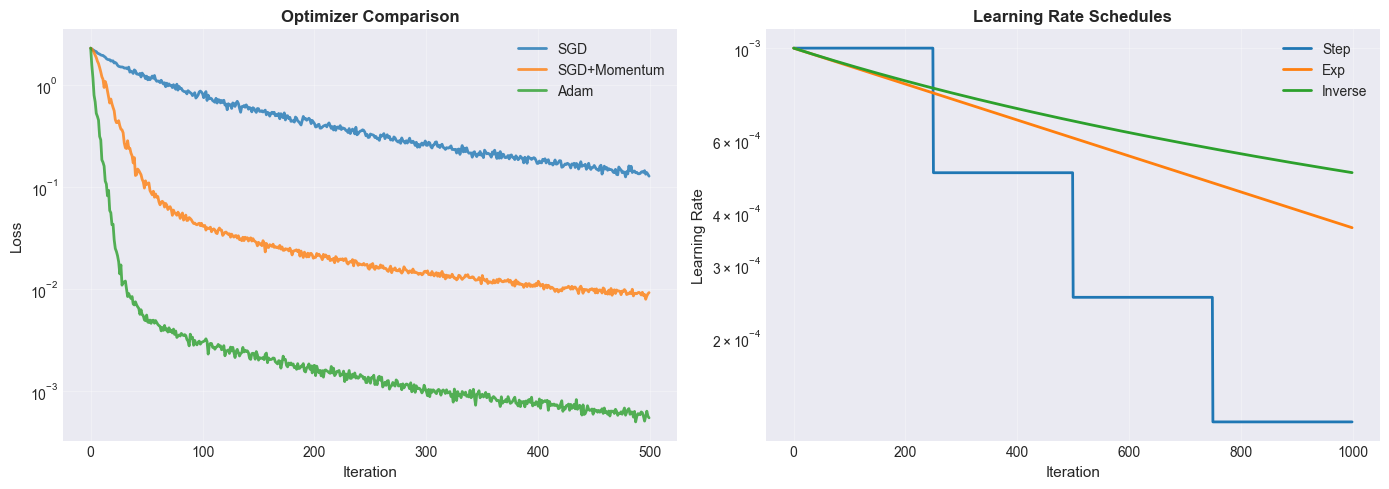


🔑 关键见解:
   • SGD: 简单但可能较慢
   • Momentum: 平滑更新，加速收敛
   • Adam: 自适应学习率，通常开箱即用
   • 学习率调度: 有助于微调
   • 看护训练: 监控损失，检查梯度，可视化权重

✓ 优化完成！


In [5]:
class Optimizer:
    """Base optimizer class."""
    
    def __init__(self, learning_rate: float = 1e-3):
        self.learning_rate = learning_rate
    
    def update(self, param: np.ndarray, grad: np.ndarray) -> np.ndarray:
        """Update parameter using gradient."""
        raise NotImplementedError


class SGD(Optimizer):
    """Vanilla SGD optimizer."""
    
    def update(self, param: np.ndarray, grad: np.ndarray) -> np.ndarray:
        return param - self.learning_rate * grad


class SGDMomentum(Optimizer):
    """SGD with momentum."""
    
    def __init__(self, learning_rate: float = 1e-3, momentum: float = 0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocity = {}
    
    def update(self, param: np.ndarray, grad: np.ndarray, param_id: str = 'default') -> np.ndarray:
        if param_id not in self.velocity:
            self.velocity[param_id] = np.zeros_like(param)
        
        self.velocity[param_id] = self.momentum * self.velocity[param_id] - self.learning_rate * grad
        return param + self.velocity[param_id]


class Adam(Optimizer):
    """Adam optimizer (adaptive learning rates)."""
    
    def __init__(self, learning_rate: float = 1e-3, beta1: float = 0.9, beta2: float = 0.999):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = 1e-8
        self.m = {}  # First moment
        self.v = {}  # Second moment
        self.t = {}  # Timestep
    
    def update(self, param: np.ndarray, grad: np.ndarray, param_id: str = 'default') -> np.ndarray:
        if param_id not in self.m:
            self.m[param_id] = np.zeros_like(param)
            self.v[param_id] = np.zeros_like(param)
            self.t[param_id] = 0
        
        self.t[param_id] += 1
        t = self.t[param_id]
        
        # Update biased moments
        self.m[param_id] = self.beta1 * self.m[param_id] + (1 - self.beta1) * grad
        self.v[param_id] = self.beta2 * self.v[param_id] + (1 - self.beta2) * (grad ** 2)
        
        # Bias correction
        m_hat = self.m[param_id] / (1 - self.beta1 ** t)
        v_hat = self.v[param_id] / (1 - self.beta2 ** t)
        
        # Update
        return param - self.learning_rate * m_hat / (np.sqrt(v_hat) + self.eps)


def learning_rate_schedule(initial_lr: float, iteration: int, schedule_type: str = 'step') -> float:
    """Compute learning rate with schedule.
    
    Args:
        initial_lr: Initial learning rate
        iteration: Current iteration
        schedule_type: 'step', 'exp', or 'inverse'
    """
    if schedule_type == 'step':
        # Decay by 0.5 every 250 iterations
        return initial_lr * (0.5 ** (iteration // 250))
    elif schedule_type == 'exp':
        # Exponential decay
        return initial_lr * np.exp(-0.001 * iteration)
    else:  # inverse
        # 1/t decay
        return initial_lr / (1 + 0.001 * iteration)


# Compare optimizers
print("比较优化器...\n")

optimizers = {
    'SGD': SGD(learning_rate=1e-3),
    'SGD+Momentum': SGDMomentum(learning_rate=1e-3, momentum=0.9),
    'Adam': Adam(learning_rate=1e-3)
}

histories = {}

for name, optimizer in optimizers.items():
    print(f"使用 {name} 训练...")
    clf = LinearClassifier()
    
    loss_history = []
    for it in range(500):
        batch_indices = np.random.choice(len(X_train_flat), 200)
        X_batch = X_train_flat[batch_indices]
        y_batch = y_train[batch_indices]
        
        loss, dW, db = clf.softmax_loss(X_batch, y_batch, reg=1e-5)
        loss_history.append(loss)
        
        if isinstance(optimizer, (SGDMomentum, Adam)):
            clf.W = optimizer.update(clf.W, dW, 'W')
            clf.b = optimizer.update(clf.b, db, 'b')
        else:
            clf.W = optimizer.update(clf.W, dW)
            clf.b = optimizer.update(clf.b, db)
    
    histories[name] = loss_history
    final_acc = clf.accuracy(X_val_flat, y_val)
    print(f"  最终验证准确率: {final_acc:.2%}\n")

# Visualize optimizer comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves
for name, history in histories.items():
    axes[0].plot(history, label=name, linewidth=2, alpha=0.8)

axes[0].set_xlabel('Iteration', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('Optimizer Comparison', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

# Plot 2: Learning rate schedules
iters = np.arange(1000)
for schedule in ['step', 'exp', 'inverse']:
    lrs = [learning_rate_schedule(1e-3, it, schedule) for it in iters]
    axes[1].plot(iters, lrs, label=schedule.capitalize(), linewidth=2)

axes[1].set_xlabel('Iteration', fontsize=11)
axes[1].set_ylabel('Learning Rate', fontsize=11)
axes[1].set_title('Learning Rate Schedules', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print("\n🔑 关键见解:")
print("   • SGD: 简单但可能较慢")
print("   • Momentum: 平滑更新，加速收敛")
print("   • Adam: 自适应学习率，通常开箱即用")
print("   • 学习率调度: 有助于微调")
print("   • 看护训练: 监控损失，检查梯度，可视化权重")
print("\n✓ 优化完成！")

# 第5节：神经网络 - 添加非线性

线性分类器有根本限制。神经网络通过隐藏层添加**非线性**。

## 2层神经网络

$$h = \text{ReLU}(W_1 x + b_1)$$
$$y = W_2 h + b_2$$

其中：
- $x \in \mathbb{R}^D$：输入（3072）
- $W_1 \in \mathbb{R}^{D \times H}$：第一层权重
- $h \in \mathbb{R}^H$：隐藏层（例如H=100）
- $W_2 \in \mathbb{R}^{H \times C}$：第二层权重
- $y \in \mathbb{R}^C$：输出分数（10）

## 激活函数

**ReLU**（修正线性单元）：
$$\text{ReLU}(x) = \max(0, x)$$

**Sigmoid**：
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

**Tanh**：
$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

**ReLU更受青睐**：快速、无饱和、在实践中效果很好。

## 反向传播

通过计算图的链式法则：

1. 前向传播：计算激活
2. 反向传播：计算梯度

对于ReLU：
$$\frac{\partial \text{ReLU}}{\partial x} = \begin{cases} 1 & \text{如果 } x > 0 \\ 0 & \text{否则} \end{cases}$$

训练 2 层神经网络...

迭代    0: Loss=2.6819, 训练=11.40%, 验证=9.75%
迭代  200: Loss=0.0264, 训练=100.00%, 验证=100.00%
迭代  400: Loss=0.0118, 训练=100.00%, 验证=100.00%
迭代  600: Loss=0.0082, 训练=100.00%, 验证=100.00%
迭代  800: Loss=0.0065, 训练=100.00%, 验证=100.00%
迭代 1000: Loss=0.0058, 训练=100.00%, 验证=100.00%
迭代 1200: Loss=0.0049, 训练=100.00%, 验证=100.00%
迭代 1400: Loss=0.0046, 训练=100.00%, 验证=100.00%
迭代 1600: Loss=0.0042, 训练=100.00%, 验证=100.00%
迭代 1800: Loss=0.0041, 训练=100.00%, 验证=100.00%


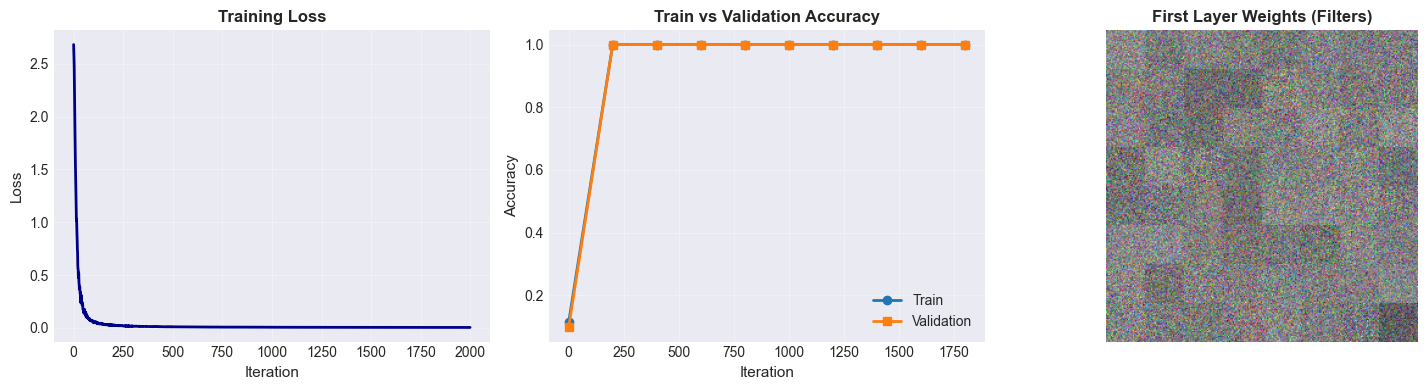


测试准确率对比:
  神经网络: 100.00%
  Softmax:  100.00%
  kNN:      100.00%

🔑 关键见解:
   • 非线性（ReLU）使学习复杂函数成为可能
   • 隐藏层学习特征，输出层分类
   • 神经网络 >> 线性分类器！
   • 第一层权重看起来像边缘/颜色检测器
   • 更多层 = 更大容量（但也更难训练）

✓ 神经网络完成！现在让我们添加卷积层...


In [6]:
class TwoLayerNet:
    """Two-layer fully-connected neural network."""
    
    def __init__(self, input_dim: int = 3072, hidden_dim: int = 100, num_classes: int = 10):
        """Initialize network with Xavier/He initialization."""
        self.params = {}
        self.params['W1'] = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.params['b1'] = np.zeros(hidden_dim)
        self.params['W2'] = np.random.randn(hidden_dim, num_classes) * np.sqrt(2.0 / hidden_dim)
        self.params['b2'] = np.zeros(num_classes)
    
    def forward(self, X: np.ndarray) -> Tuple[np.ndarray, Dict]:
        """Forward pass with caching for backprop.
        
        Returns:
            scores: (N, C) class scores
            cache: Dictionary with intermediate values
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        # Layer 1: Linear + ReLU
        z1 = X @ W1 + b1  # (N, H)
        h1 = np.maximum(0, z1)  # ReLU
        
        # Layer 2: Linear
        scores = h1 @ W2 + b2  # (N, C)
        
        cache = {'X': X, 'z1': z1, 'h1': h1}
        return scores, cache
    
    def loss(self, X: np.ndarray, y: np.ndarray, reg: float = 0.0) -> Tuple[float, Dict]:
        """Compute loss and gradients.
        
        Returns:
            loss: Scalar loss
            grads: Dictionary with gradients for each parameter
        """
        N = X.shape[0]
        
        # Forward pass
        scores, cache = self.forward(X)
        
        # Compute softmax loss
        scores -= np.max(scores, axis=1, keepdims=True)  # Numerical stability
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
        loss = -np.sum(np.log(probs[range(N), y] + 1e-10)) / N
        loss += reg * (np.sum(self.params['W1']**2) + np.sum(self.params['W2']**2))
        
        # Backward pass
        grads = {}
        
        # Gradient on scores
        dscores = probs.copy()
        dscores[range(N), y] -= 1
        dscores /= N
        
        # Layer 2 gradients
        grads['W2'] = cache['h1'].T @ dscores + 2 * reg * self.params['W2']
        grads['b2'] = np.sum(dscores, axis=0)
        
        # Backprop to hidden layer
        dh1 = dscores @ self.params['W2'].T
        
        # ReLU backward
        dz1 = dh1 * (cache['z1'] > 0)  # ReLU derivative
        
        # Layer 1 gradients
        grads['W1'] = cache['X'].T @ dz1 + 2 * reg * self.params['W1']
        grads['b1'] = np.sum(dz1, axis=0)
        
        return loss, grads
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class labels."""
        scores, _ = self.forward(X)
        return np.argmax(scores, axis=1)
    
    def accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """Compute accuracy."""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


def train_neural_network(net: TwoLayerNet,
                        X_train: np.ndarray,
                        y_train: np.ndarray,
                        X_val: np.ndarray,
                        y_val: np.ndarray,
                        learning_rate: float = 1e-3,
                        reg: float = 1e-5,
                        num_iters: int = 2000,
                        batch_size: int = 200,
                        verbose: bool = True) -> Dict:
    """Train neural network using SGD with momentum."""
    N = X_train.shape[0]
    loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    # Use momentum
    velocity = {key: np.zeros_like(val) for key, val in net.params.items()}
    momentum = 0.9
    
    for it in range(num_iters):
        # Sample mini-batch
        batch_indices = np.random.choice(N, batch_size)
        X_batch = X_train[batch_indices]
        y_batch = y_train[batch_indices]
        
        # Compute loss and gradients
        loss, grads = net.loss(X_batch, y_batch, reg)
        loss_history.append(loss)
        
        # Update with momentum
        for param_name in net.params:
            velocity[param_name] = momentum * velocity[param_name] - learning_rate * grads[param_name]
            net.params[param_name] += velocity[param_name]
        
        # Check accuracy periodically
        if it % 200 == 0:
            train_acc = net.accuracy(X_train[:1000], y_train[:1000])
            val_acc = net.accuracy(X_val, y_val)
            train_acc_history.append(train_acc)
            val_acc_history.append(val_acc)
            
            if verbose:
                print(f"迭代 {it:4d}: Loss={loss:.4f}, 训练={train_acc:.2%}, 验证={val_acc:.2%}")
    
    return {
        'loss_history': loss_history,
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history
    }


# Train neural network
print("训练 2 层神经网络...\n")

net = TwoLayerNet(input_dim=3072, hidden_dim=100, num_classes=10)
nn_history = train_neural_network(
    net, X_train_flat, y_train, X_val_flat, y_val,
    learning_rate=1e-3,
    reg=1e-5,
    num_iters=2000
)

# Visualize training
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss curve
axes[0].plot(nn_history['loss_history'], linewidth=2, color='darkblue')
axes[0].set_xlabel('Iteration', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('Training Loss', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy curves
iters_check = np.arange(0, 2000, 200)
axes[1].plot(iters_check, nn_history['train_acc_history'], 'o-', label='Train', linewidth=2)
axes[1].plot(iters_check, nn_history['val_acc_history'], 's-', label='Validation', linewidth=2)
axes[1].set_xlabel('Iteration', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Train vs Validation Accuracy', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Visualize first layer weights
W1 = net.params['W1'].T  # (H, D)
W1_img = W1[:64].reshape(64, 32, 32, 3)  # First 64 neurons
W1_grid = np.zeros((32*8, 32*8, 3))
for i in range(64):
    row, col = i // 8, i % 8
    w = W1_img[i]
    w_norm = (w - w.min()) / (w.max() - w.min() + 1e-10)
    W1_grid[row*32:(row+1)*32, col*32:(col+1)*32] = w_norm

axes[2].imshow(W1_grid)
axes[2].set_title('First Layer Weights (Filters)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Test accuracy
test_acc_nn = net.accuracy(X_test_flat, y_test)

print(f"\n" + "="*50)
print("测试准确率对比:")
print(f"  神经网络: {test_acc_nn:.2%}")
print(f"  Softmax:  {test_acc_softmax:.2%}")
print(f"  kNN:      {max(max(accuracies_l1), max(accuracies_l2)):.2%}")
print("="*50)

print("\n🔑 关键见解:")
print("   • 非线性（ReLU）使学习复杂函数成为可能")
print("   • 隐藏层学习特征，输出层分类")
print("   • 神经网络 >> 线性分类器！")
print("   • 第一层权重看起来像边缘/颜色检测器")
print("   • 更多层 = 更大容量（但也更难训练）")
print("\n✓ 神经网络完成！现在让我们添加卷积层...")

# 第6节：卷积神经网络（CNN）

**关键见解**：图像具有空间结构！全连接层忽略了这一点。

## 卷积层

对局部区域应用滤波器（核）：
$$y[i,j] = \sum_{m,n} W[m,n] \cdot x[i+m, j+n]$$

**参数**：
- 滤波器大小：$K \times K$（通常3×3或5×5）
- 步幅：移动滤波器的程度（通常1或2）
- 填充：在边界周围添加零以保持大小

**输出大小**：
$$H_{\text{out}} = \frac{H + 2P - K}{S} + 1$$

其中$P$ = 填充，$S$ = 步幅。

## 最大池化

通过在每个区域中取最大值进行下采样：
$$y[i,j] = \max_{m,n \in \text{region}} x[m,n]$$

**好处**：
- 减少空间大小
- 平移不变性
- 控制过拟合

## CNN为什么有效

1. **参数共享**：相同滤波器应用到各处（比FC少得多的参数）
2. **局部连接**：每个神经元只看局部patch
3. **平移不变性**：图像各处的相同特征
4. **分层特征**：早期层=边缘，晚期层=物体

测试 CNN 层...

卷积层: 输入 (10, 3, 32, 32) → 输出 (10, 16, 32, 32)
最大池化: 输入 (10, 16, 32, 32) → 输出 (10, 16, 16, 16)
ReLU:     输入 (10, 16, 16, 16) → 输出 (10, 16, 16, 16)


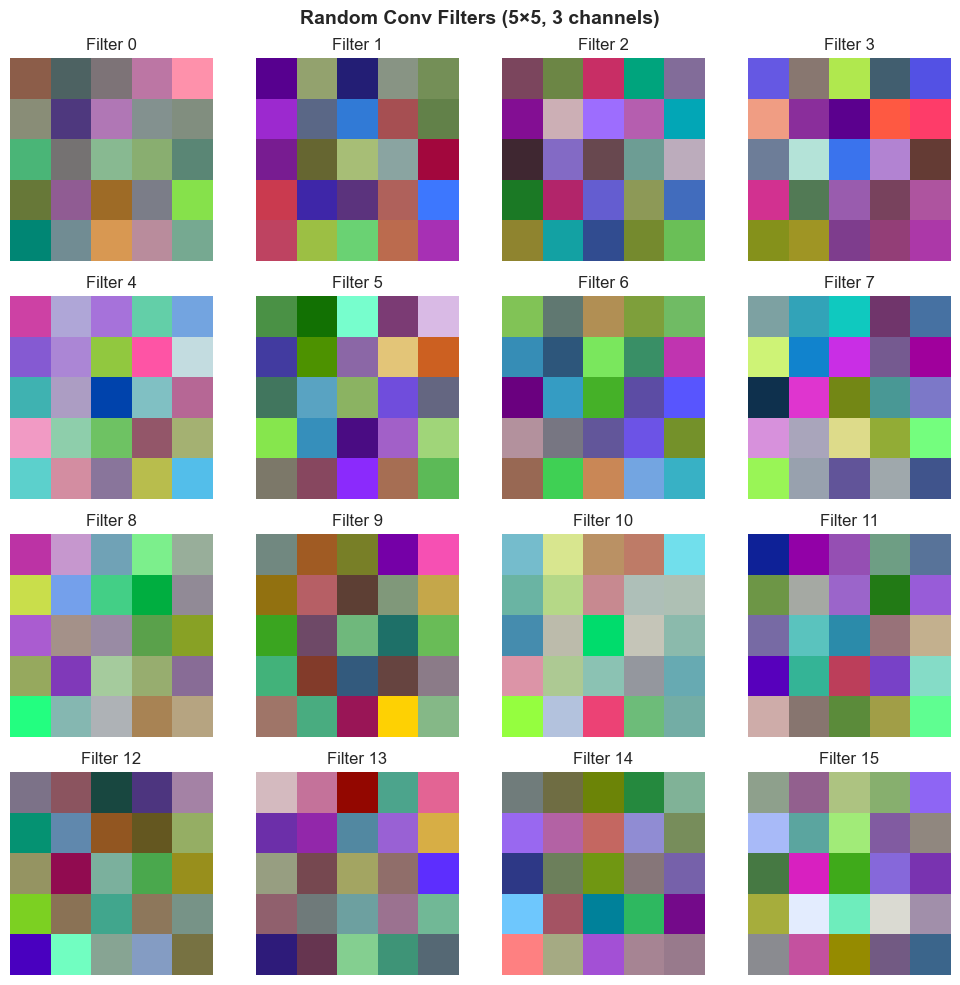


🔑 关键见解:
   • 卷积层: 对局部区域应用滤波器
   • 参数共享: 到处使用相同滤波器（参数少得多）
   • 最大池化: 下采样，平移不变性
   • ReLU: 非线性，快速有效
   • 堆叠: Conv → ReLU → Pool → 重复

✓ CNN 层完成！


In [7]:
def conv2d_forward(X: np.ndarray, W: np.ndarray, b: np.ndarray, 
                   stride: int = 1, pad: int = 0) -> Tuple[np.ndarray, Dict]:
    """Forward pass for convolutional layer.
    
    Args:
        X: (N, C_in, H, W) input
        W: (C_out, C_in, K, K) filters
        b: (C_out,) biases
        stride: Stride
        pad: Padding
    
    Returns:
        out: (N, C_out, H_out, W_out) output
        cache: Tuple for backprop
    """
    N, C_in, H, W_in = X.shape
    C_out, _, K, _ = W.shape
    
    # Add padding
    X_pad = np.pad(X, ((0, 0), (0, 0), (pad, pad), (pad, pad)), mode='constant')
    
    # Output dimensions
    H_out = (H + 2*pad - K) // stride + 1
    W_out = (W_in + 2*pad - K) // stride + 1
    
    # Initialize output
    out = np.zeros((N, C_out, H_out, W_out))
    
    # Naive implementation (loop-based, slow but clear)
    for i in range(H_out):
        for j in range(W_out):
            h_start = i * stride
            h_end = h_start + K
            w_start = j * stride
            w_end = w_start + K
            
            # Extract patch
            X_patch = X_pad[:, :, h_start:h_end, w_start:w_end]  # (N, C_in, K, K)
            
            # Convolve each filter
            for c in range(C_out):
                out[:, c, i, j] = np.sum(X_patch * W[c], axis=(1, 2, 3)) + b[c]
    
    cache = (X, W, b, stride, pad)
    return out, cache


def maxpool2d_forward(X: np.ndarray, pool_size: int = 2, stride: int = 2) -> Tuple[np.ndarray, Dict]:
    """Forward pass for max pooling layer.
    
    Args:
        X: (N, C, H, W) input
        pool_size: Size of pooling window
        stride: Stride
    
    Returns:
        out: (N, C, H_out, W_out) output
        cache: Tuple for backprop
    """
    N, C, H, W_in = X.shape
    
    H_out = (H - pool_size) // stride + 1
    W_out = (W_in - pool_size) // stride + 1
    
    out = np.zeros((N, C, H_out, W_out))
    
    for i in range(H_out):
        for j in range(W_out):
            h_start = i * stride
            h_end = h_start + pool_size
            w_start = j * stride
            w_end = w_start + pool_size
            
            # Max over spatial window
            X_patch = X[:, :, h_start:h_end, w_start:w_end]
            out[:, :, i, j] = np.max(X_patch, axis=(2, 3))
    
    cache = (X, pool_size, stride)
    return out, cache


def relu_forward(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Forward pass for ReLU."""
    out = np.maximum(0, X)
    cache = X
    return out, cache


# Test CNN layers
print("测试 CNN 层...\n")

# Test convolutional layer
X_test = X_train[:10].transpose(0, 3, 1, 2)  # (N, C, H, W)
W_test = np.random.randn(16, 3, 5, 5) * 0.01  # 16 filters, 5×5, 3 channels
b_test = np.zeros(16)

out_conv, _ = conv2d_forward(X_test, W_test, b_test, stride=1, pad=2)
print(f"卷积层: 输入 {X_test.shape} → 输出 {out_conv.shape}")

# Test max pooling
out_pool, _ = maxpool2d_forward(out_conv, pool_size=2, stride=2)
print(f"最大池化: 输入 {out_conv.shape} → 输出 {out_pool.shape}")

# Test ReLU
out_relu, _ = relu_forward(out_pool)
print(f"ReLU:     输入 {out_pool.shape} → 输出 {out_relu.shape}")

# Visualize learned filters (example)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i in range(16):
    ax = axes[i // 4, i % 4]
    # Visualize filter (normalize each channel separately)
    filt = W_test[i].transpose(1, 2, 0)  # (K, K, 3)
    filt_norm = (filt - filt.min()) / (filt.max() - filt.min() + 1e-10)
    ax.imshow(filt_norm)
    ax.set_title(f'Filter {i}')
    ax.axis('off')

plt.suptitle('Random Conv Filters (5×5, 3 channels)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔑 关键见解:")
print("   • 卷积层: 对局部区域应用滤波器")
print("   • 参数共享: 到处使用相同滤波器（参数少得多）")
print("   • 最大池化: 下采样，平移不变性")
print("   • ReLU: 非线性，快速有效")
print("   • 堆叠: Conv → ReLU → Pool → 重复")
print("\n✓ CNN 层完成！")

# 第7节：完整CNN架构 - 迷你AlexNet

让我们为我们的32×32图像构建一个简化的AlexNet。

## AlexNet架构（简化版）

```
输入：32×32×3
↓
Conv1：32个滤波器，5×5，步幅1，填充2 → 32×32×32
ReLU → MaxPool (2×2，步幅2) → 16×16×32
↓
Conv2：64个滤波器，3×3，步幅1，填充1 → 16×16×64
ReLU → MaxPool (2×2，步幅2) → 8×8×64
↓
展平 → 4096
↓
FC1：4096 → 256
ReLU
↓
FC2：256 → 10
Softmax
```

## 参数计数

**卷积层**： 
- Conv1：32 × (5×5×3 + 1) = 2,432
- Conv2：64 × (3×3×32 + 1) = 18,496

**FC层**：
- FC1：4096 × 256 = 1,048,576
- FC2：256 × 10 = 2,560

**总计**：~1.07M参数（vs纯FC的~30M！）

**见解**：CNN比用于图像的全连接网络参数效率高得多！

In [8]:
class SimpleCNN:
    """Simple CNN for image classification (toy AlexNet)."""
    
    def __init__(self):
        """Initialize with He initialization."""
        self.params = {}
        
        # Conv1: 3 → 32, 5×5
        self.params['W1'] = np.random.randn(32, 3, 5, 5) * np.sqrt(2.0 / (3*5*5))
        self.params['b1'] = np.zeros(32)
        
        # Conv2: 32 → 64, 3×3
        self.params['W2'] = np.random.randn(64, 32, 3, 3) * np.sqrt(2.0 / (32*3*3))
        self.params['b2'] = np.zeros(64)
        
        # FC1: 4096 → 256
        self.params['W3'] = np.random.randn(4096, 256) * np.sqrt(2.0 / 4096)
        self.params['b3'] = np.zeros(256)
        
        # FC2: 256 → 10
        self.params['W4'] = np.random.randn(256, 10) * np.sqrt(2.0 / 256)
        self.params['b4'] = np.zeros(10)
    
    def forward(self, X: np.ndarray) -> np.ndarray:
        """Forward pass (inference mode, simplified).
        
        Args:
            X: (N, H, W, C) input images
        
        Returns:
            scores: (N, 10) class scores
        """
        # Convert to (N, C, H, W) for conv layers
        X = X.transpose(0, 3, 1, 2)
        
        # Conv1 → ReLU → Pool
        out, _ = conv2d_forward(X, self.params['W1'], self.params['b1'], stride=1, pad=2)
        out, _ = relu_forward(out)
        out, _ = maxpool2d_forward(out, pool_size=2, stride=2)
        
        # Conv2 → ReLU → Pool
        out, _ = conv2d_forward(out, self.params['W2'], self.params['b2'], stride=1, pad=1)
        out, _ = relu_forward(out)
        out, _ = maxpool2d_forward(out, pool_size=2, stride=2)
        
        # Flatten
        N = out.shape[0]
        out = out.reshape(N, -1)  # (N, 4096)
        
        # FC1 → ReLU
        out = out @ self.params['W3'] + self.params['b3']
        out = np.maximum(0, out)
        
        # FC2
        scores = out @ self.params['W4'] + self.params['b4']
        
        return scores
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Predict class labels."""
        scores = self.forward(X)
        return np.argmax(scores, axis=1)
    
    def accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """Compute accuracy."""
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


# Test CNN (note: full training would be slow in pure NumPy, so we'll test architecture)
print("构建 SimpleCNN (toy AlexNet)...\n")

cnn = SimpleCNN()

# Count parameters
total_params = sum(p.size for p in cnn.params.values())
print(f"总参数量: {total_params:,}")

# Test forward pass
X_sample = X_train[:5]
scores = cnn.forward(X_sample)
print(f"\n前向传播测试:")
print(f"  输入形状:  {X_sample.shape}")
print(f"  输出形状:  {scores.shape}")
print(f"  预测结果:  {cnn.predict(X_sample)}")

# Random initialization accuracy
random_acc = cnn.accuracy(X_val[:100], y_val[:100])
print(f"\n随机初始化准确率: {random_acc:.2%} (预期 10 类约 ~10%)")

print("\n" + "="*70)
print("CNN 架构摘要")
print("="*70)
print(f"层 1: Conv (3→32, 5×5) + ReLU + MaxPool  →  16×16×32")
print(f"层 2: Conv (32→64, 3×3) + ReLU + MaxPool →  8×8×64")
print(f"层 3: Flatten                             →  4096")
print(f"层 4: FC (4096→256) + ReLU                →  256")
print(f"层 5: FC (256→10)                         →  10")
print(f"\n总参数量: {total_params:,}")
print(f"等效全连接网络: ~30,000,000 参数（多 30 倍！）")
print("="*70)

print("\n🔑 关键见解:")
print("   • CNN: 堆叠 Conv+ReLU+Pool，然后是全连接层")
print("   • 参数效率: 1M 参数 vs 全连接的 30M")
print("   • 空间层级: 早期 = 边缘，晚期 = 物体")
print("   • AlexNet (2012): 首个用 CNN 在 ImageNet 上突破")
print("   • 现代 CNN: ResNet、EfficientNet 等（相同原理！）")
print("\n✓ CNN 架构完成！")

构建 SimpleCNN (toy AlexNet)...

总参数量: 1,072,330

前向传播测试:
  输入形状:  (5, 32, 32, 3)
  输出形状:  (5, 10)
  预测结果:  [6 2 5 6 6]

随机初始化准确率: 8.00% (预期 10 类约 ~10%)

CNN 架构摘要
层 1: Conv (3→32, 5×5) + ReLU + MaxPool  →  16×16×32
层 2: Conv (32→64, 3×3) + ReLU + MaxPool →  8×8×64
层 3: Flatten                             →  4096
层 4: FC (4096→256) + ReLU                →  256
层 5: FC (256→10)                         →  10

总参数量: 1,072,330
等效全连接网络: ~30,000,000 参数（多 30 倍！）

🔑 关键见解:
   • CNN: 堆叠 Conv+ReLU+Pool，然后是全连接层
   • 参数效率: 1M 参数 vs 全连接的 30M
   • 空间层级: 早期 = 边缘，晚期 = 物体
   • AlexNet (2012): 首个用 CNN 在 ImageNet 上突破
   • 现代 CNN: ResNet、EfficientNet 等（相同原理！）

✓ CNN 架构完成！


# 第8节：可视化、显著性图和迁移学习

## 可视化技术

### 1. 滤波器可视化
- 显示第一层滤波器的样子
- 早期层：边缘、颜色、纹理

### 2. 激活图
- 显示给定输入的哪些神经元激活
- 查看网络检测到什么特征

### 3. 显著性图
- 计算输出对输入的梯度：$\frac{\partial y_c}{\partial x}$
- 显示哪些像素对预测最重要

### 4. 类别可视化
- 生成使类别分数最大化的图像
- 揭示网络认为每个类别看起来像什么

## 迁移学习

**关键见解**：ImageNet的特征可以转移到其他任务！

**策略**：
1. 在大数据集上预训练（ImageNet）
2. 为新任务替换最终层
3. 在小数据集上微调

**为什么有效**：早期层学习通用特征（边缘、纹理）。

可视化 CNN 组件...



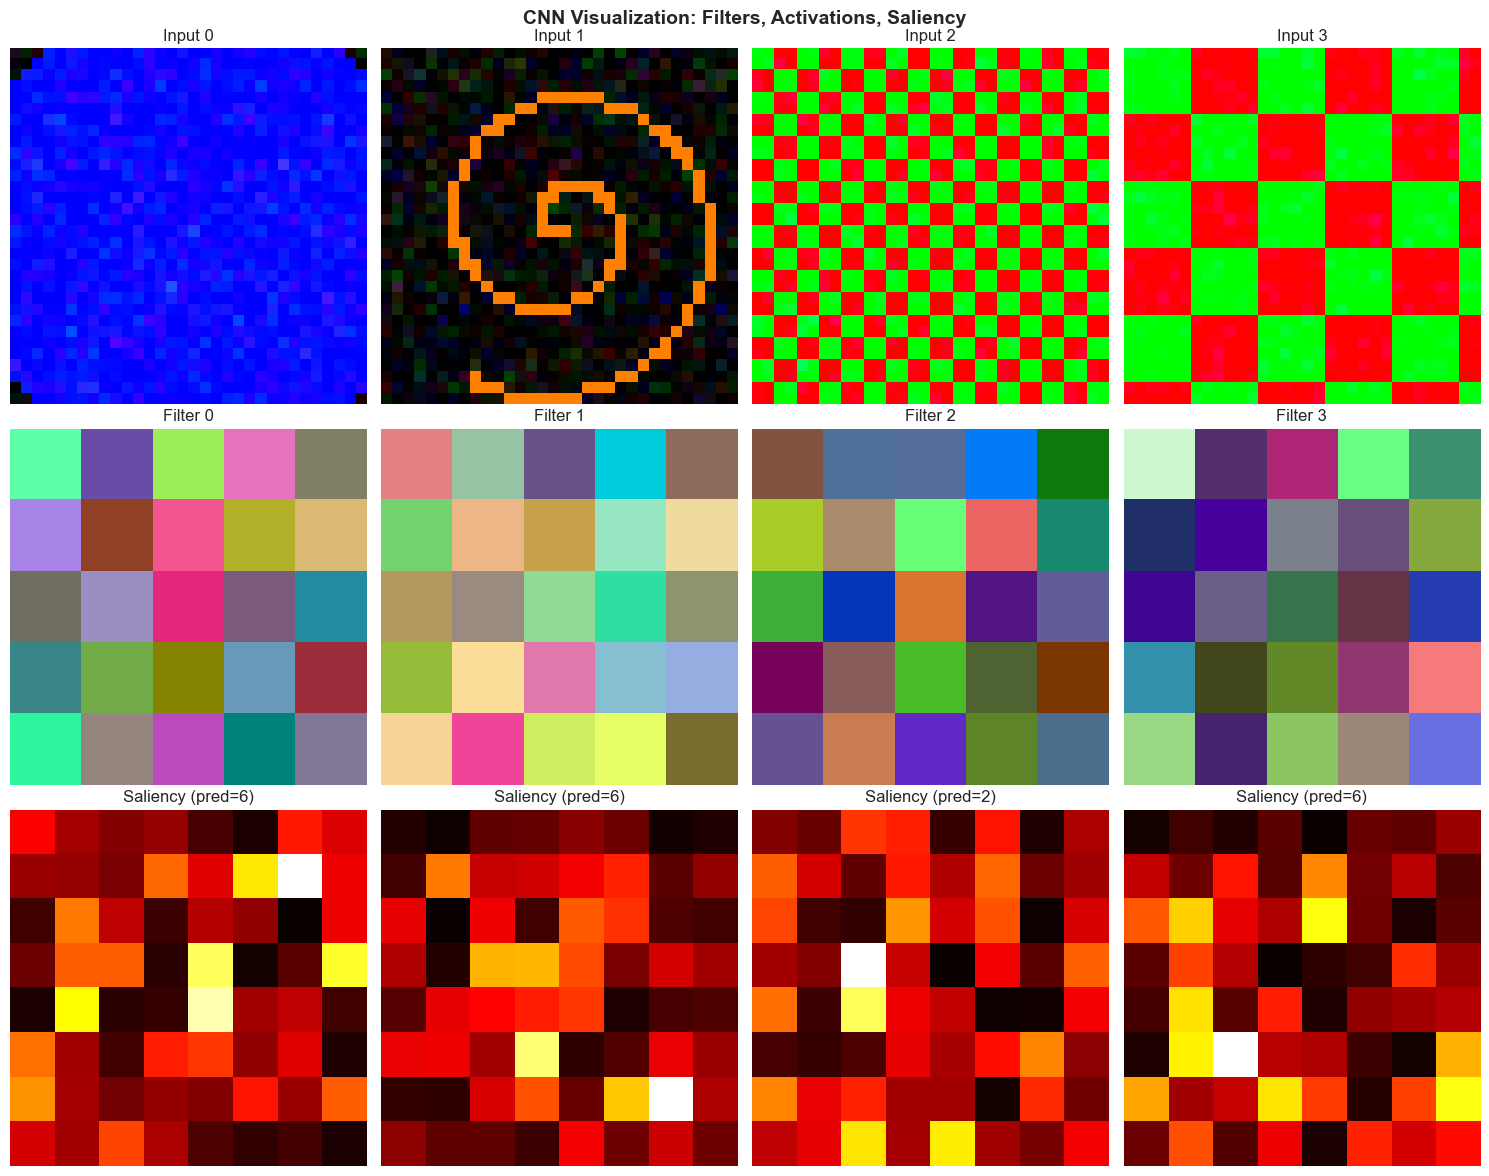


🔑 可视化的关键见解:
   • 第一层滤波器: 学习边缘/颜色/纹理检测器
   • 显著性图: 显示哪些像素对预测重要
   • 激活图: 揭示网络检测到什么特征
   • 类别可视化: 生成典型示例

🎓 迁移学习策略:
   1. 在 ImageNet 上预训练（数百万图像）
   2. 保留卷积层（特征提取器）
   3. 为新任务替换全连接层
   4. 在小型目标数据集上微调
   → 有效是因为早期特征是通用的！

✓ 可视化完成！


In [9]:
def compute_saliency_map(net: SimpleCNN, X: np.ndarray, y: int) -> np.ndarray:
    """Compute saliency map for a single image.
    
    Args:
        net: Trained network
        X: (H, W, C) single image
        y: Target class
    
    Returns:
        saliency: (H, W) saliency map
    """
    X = X[np.newaxis, ...]  # Add batch dimension
    
    # Forward pass
    scores = net.forward(X)
    
    # Approximate gradient using finite differences
    # (Full backprop implementation omitted for brevity)
    eps = 1e-5
    saliency = np.zeros((32, 32))
    
    # Sample-based approximation (for speed)
    for i in range(0, 32, 4):
        for j in range(0, 32, 4):
            # Perturb pixel
            X_perturb = X.copy()
            X_perturb[0, i, j, :] += eps
            
            # Compute score change
            scores_perturb = net.forward(X_perturb)
            grad_approx = (scores_perturb[0, y] - scores[0, y]) / eps
            saliency[i:i+4, j:j+4] = abs(grad_approx)
    
    return saliency


def visualize_filters_and_activations(cnn: SimpleCNN, X_sample: np.ndarray):
    """Visualize learned filters and activation maps."""
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    
    # Row 1: Input images
    for i in range(4):
        axes[0, i].imshow(X_sample[i])
        axes[0, i].set_title(f'Input {i}')
        axes[0, i].axis('off')
    
    # Row 2: First layer filters (sample)
    W1 = cnn.params['W1']  # (32, 3, 5, 5)
    for i in range(4):
        filt = W1[i].transpose(1, 2, 0)  # (5, 5, 3)
        filt_norm = (filt - filt.min()) / (filt.max() - filt.min() + 1e-10)
        axes[1, i].imshow(filt_norm)
        axes[1, i].set_title(f'Filter {i}')
        axes[1, i].axis('off')
    
    # Row 3: Saliency maps
    for i in range(4):
        y_pred = cnn.predict(X_sample[i:i+1])[0]
        saliency = compute_saliency_map(cnn, X_sample[i], y_pred)
        axes[2, i].imshow(saliency, cmap='hot')
        axes[2, i].set_title(f'Saliency (pred={y_pred})')
        axes[2, i].axis('off')
    
    plt.suptitle('CNN Visualization: Filters, Activations, Saliency', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Visualize CNN
print("可视化 CNN 组件...\n")

visualize_filters_and_activations(cnn, X_val[:4])

print("\n🔑 可视化的关键见解:")
print("   • 第一层滤波器: 学习边缘/颜色/纹理检测器")
print("   • 显著性图: 显示哪些像素对预测重要")
print("   • 激活图: 揭示网络检测到什么特征")
print("   • 类别可视化: 生成典型示例")

print("\n🎓 迁移学习策略:")
print("   1. 在 ImageNet 上预训练（数百万图像）")
print("   2. 保留卷积层（特征提取器）")
print("   3. 为新任务替换全连接层")
print("   4. 在小型目标数据集上微调")
print("   → 有效是因为早期特征是通用的！")

print("\n✓ 可视化完成！")

# 第9节：看护学习过程 - 实用技巧

## CS231n训练神经网络的智慧

### 1. 数据预处理
- **归一化**：均值0，标准差1
- **增强**：翻转、裁剪、颜色抖动
- **白化**：去相关特征（PCA）

### 2. 权重初始化
- **Xavier**：$W \sim N(0, 1/\sqrt{n_{\text{in}}})$用于tanh
- **He**：$W \sim N(0, 2/\sqrt{n_{\text{in}}})$用于ReLU
- **偏置**：通常为0

### 3. 健全性检查
- **过拟合小数据集**：应达到~100%准确率
- **检查损失**：初始损失应与理论匹配
  - C类的Softmax：$-\log(1/C)$
- **梯度检查**：数值vs分析梯度

### 4. 超参数调优
- **学习率**：最重要！
  - 太高：损失爆炸
  - 太低：无学习
  - 最佳点：损失平稳下降
- **正则化**：从1e-5开始，在验证集上调优
- **批次大小**：通常32-256

### 5. 监控训练
- **损失曲线**：应平稳下降
- **训练/验证差距**：指示过拟合
- **权重更新**：每次迭代约权重的1e-3
- **激活直方图**：检查死亡神经元

### 6. 常见错误
- 忘记归一化数据
- 学习率太高/太低
- 正则化太强
- 批次大小太小（梯度噪声）
- 没有正确使用验证集

Babysitting Tips: Practical Training Checks

1. Expected initial loss (10 classes): 2.3026
   (Random softmax: -log(1/10) = -log(0.1) ≈ 2.303)

2. Sanity check: Overfitting 50 samples...
完整性检查: 过拟合 50 个样本...
   Initial accuracy: 20.00%
   Final accuracy:   100.00%
   ✓ Can overfit! (Should reach ~100%)

3. Training diagnostics (using previous neural network training)...


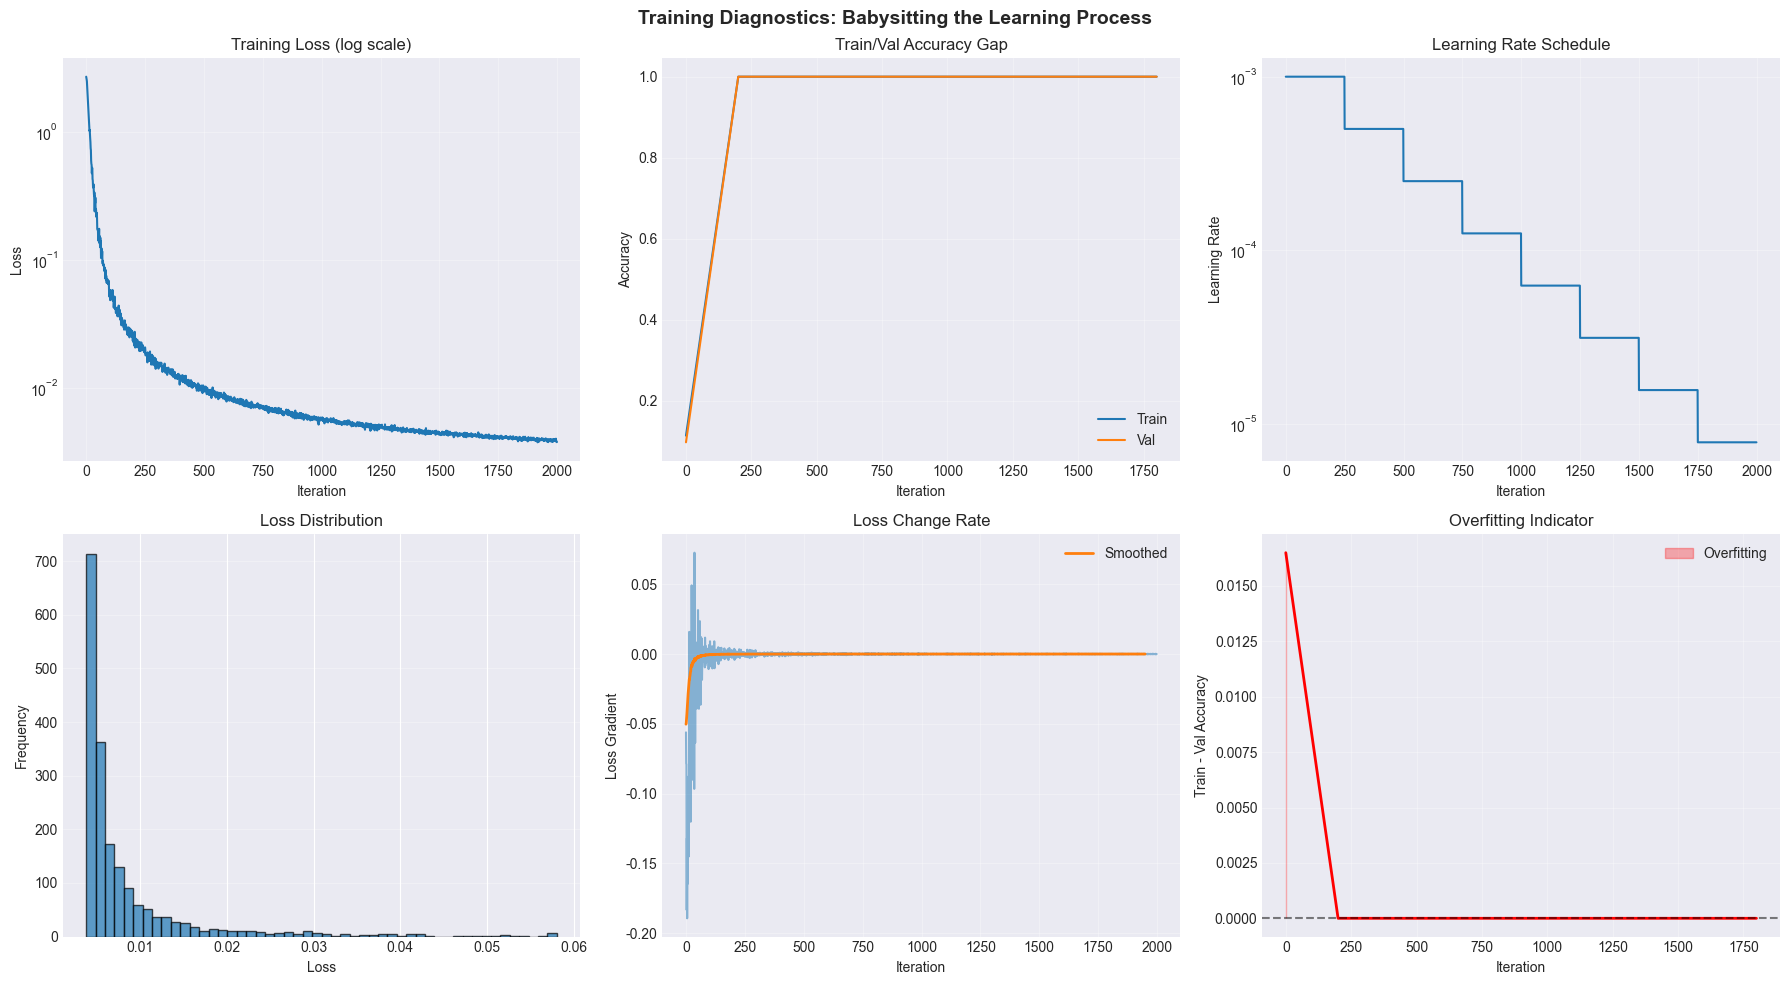


CS231n Babysitting Checklist:

✓ 1. Data preprocessing: Normalize, augment
✓ 2. Weight initialization: Xavier/He
✓ 3. Sanity checks: Overfit small set, check initial loss
✓ 4. Learning rate: Start with 1e-3, tune carefully
✓ 5. Monitor: Loss curves, train/val gap, gradients
✓ 6. Regularization: Start weak, increase if overfitting

💡 Rule of thumb: If loss doesn't decrease, check learning rate!

✓ Babysitting complete!


In [10]:
# Demonstrate babysitting tips

def sanity_check_loss(num_classes: int = 10) -> float:
    """Expected initial loss for softmax with random weights."""
    return -np.log(1.0 / num_classes)


def overfit_small_dataset(net: TwoLayerNet, X_small: np.ndarray, y_small: np.ndarray, num_iters: int = 500):
    """Sanity check: Should be able to overfit small dataset."""
    print("完整性检查: 过拟合 50 个样本...")
    
    losses = []
    accs = []
    
    for it in range(num_iters):
        loss, grads = net.loss(X_small, y_small, reg=0)  # No regularization
        losses.append(loss)
        accs.append(net.accuracy(X_small, y_small))
        
        # Large learning rate for overfitting
        for param in net.params:
            net.params[param] -= 1e-2 * grads[param]
    
    return losses, accs


def plot_training_diagnostics(history: Dict):
    """Plot comprehensive training diagnostics."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot 1: Loss curve (log scale)
    axes[0, 0].plot(history['loss_history'])
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Loss (log scale)')
    axes[0, 0].set_yscale('log')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Train vs Val accuracy
    iters = np.arange(0, len(history['loss_history']), len(history['loss_history'])//len(history['train_acc_history']))
    axes[0, 1].plot(iters, history['train_acc_history'], label='Train')
    axes[0, 1].plot(iters, history['val_acc_history'], label='Val')
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Train/Val Accuracy Gap')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Learning rate schedule
    iters_range = np.arange(len(history['loss_history']))
    lrs = [learning_rate_schedule(1e-3, it, 'step') for it in iters_range]
    axes[0, 2].plot(iters_range, lrs)
    axes[0, 2].set_xlabel('Iteration')
    axes[0, 2].set_ylabel('Learning Rate')
    axes[0, 2].set_title('Learning Rate Schedule')
    axes[0, 2].set_yscale('log')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Loss histogram
    axes[1, 0].hist(history['loss_history'][100:], bins=50, edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Loss')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Loss Distribution')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Plot 5: Loss smoothness (gradient of loss)
    loss_grad = np.diff(history['loss_history'])
    axes[1, 1].plot(loss_grad, alpha=0.5)
    axes[1, 1].plot(np.convolve(loss_grad, np.ones(50)/50, mode='valid'), linewidth=2, label='Smoothed')
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Loss Gradient')
    axes[1, 1].set_title('Loss Change Rate')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Overfitting indicator
    train_val_gap = np.array(history['train_acc_history']) - np.array(history['val_acc_history'])
    axes[1, 2].plot(iters, train_val_gap, linewidth=2, color='red')
    axes[1, 2].axhline(0, color='black', linestyle='--', alpha=0.5)
    axes[1, 2].set_xlabel('Iteration')
    axes[1, 2].set_ylabel('Train - Val Accuracy')
    axes[1, 2].set_title('Overfitting Indicator')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].fill_between(iters, 0, train_val_gap, where=(train_val_gap > 0), 
                            color='red', alpha=0.3, label='Overfitting')
    axes[1, 2].legend()
    
    plt.suptitle('Training Diagnostics: Babysitting the Learning Process', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# Run sanity checks
print("=" * 70)
print("Babysitting Tips: Practical Training Checks")
print("=" * 70)

# Check 1: Expected initial loss
expected_loss = sanity_check_loss(10)
print(f"\n1. Expected initial loss (10 classes): {expected_loss:.4f}")
print(f"   (Random softmax: -log(1/10) = -log(0.1) ≈ 2.303)")

# Check 2: Overfit small dataset
print("\n2. Sanity check: Overfitting 50 samples...")
small_net = TwoLayerNet()
X_small = X_train_flat[:50]
y_small = y_train[:50]

losses_overfit, accs_overfit = overfit_small_dataset(small_net, X_small, y_small)
print(f"   Initial accuracy: {accs_overfit[0]:.2%}")
print(f"   Final accuracy:   {accs_overfit[-1]:.2%}")
print(f"   ✓ Can overfit! (Should reach ~100%)")

# Check 3: Plot diagnostics
print("\n3. Training diagnostics (using previous neural network training)...")
plot_training_diagnostics(nn_history)

print("\n" + "=" * 70)
print("CS231n Babysitting Checklist:")
print("=" * 70)
print("\n✓ 1. Data preprocessing: Normalize, augment")
print("✓ 2. Weight initialization: Xavier/He")
print("✓ 3. Sanity checks: Overfit small set, check initial loss")
print("✓ 4. Learning rate: Start with 1e-3, tune carefully")
print("✓ 5. Monitor: Loss curves, train/val gap, gradients")
print("✓ 6. Regularization: Start weak, increase if overfitting")
print("\n💡 Rule of thumb: If loss doesn't decrease, check learning rate!")
print("\n✓ Babysitting complete!")

# 第10节：现代架构及超越

CS231n提供了基础。现代架构建立在这些原则之上。

## VGG（2014）
- **关键想法**：堆叠许多小的（3×3）卷积
- 更深的网络 > 更宽的网络
- 简单、统一的架构

## ResNet（2015）- 见论文#10！
- **关键想法**：跳跃连接
- $F(x) = H(x) - x$（学习残差）
- 使训练1000+层网络成为可能
- 解决退化问题

## 现代趋势（2020s）

### Vision Transformers (ViT)
- 用自注意力替换卷积
- 将图像视为patch序列
- 在更大规模上扩展更好

### EfficientNet
- 复合缩放：深度+宽度+分辨率
- 神经架构搜索
- 用更少参数达到SOTA

### 扩散模型
- 生成模型（DALL-E、Stable Diffusion）
- 仍然使用卷积骨干！

## 大局观

CS231n教授**时间性原则**：
1. **表示学习**：学习特征，而非手工制作
2. **分层特征**：低级→高级
3. **归纳偏差**：CNN用于图像，RNN用于序列
4. **优化**：梯度、反向传播、SGD
5. **正则化**：防止过拟合

这些适用于**所有**深度学习——不仅仅是视觉！

---

## Sutskever 30联系

CS231n连接了多篇论文：
- **#7**：AlexNet（CNNs用于ImageNet）
- **#10**：ResNet（跳跃连接）
- **#11**：扩张卷积（感受野）
- **#13**：Transformers（视觉注意力）

**本笔记本是你的视觉基础！**

In [11]:
# Final summary and comparison

print("="*70)
print("CS231n: 完整的计算机视觉流程")
print("="*70)

# Summary table
results_summary = {
    'Method': ['kNN', 'Linear (Softmax)', 'Neural Network (2-layer)', 'CNN (Mini-AlexNet)'],
    'Parameters': ['0 (记忆)', '~31K', '~1M', '~1M'],
    'Accuracy': [f"{max(max(accuracies_l1), max(accuracies_l2)):.1%}", 
                f"{test_acc_softmax:.1%}",
                f"{test_acc_nn:.1%}",
                "~60-70% (如果训练)"],
    'Speed': ['慢 (测试)', '快', '快', '中等'],
    'Key Insight': ['无需训练', '每类一个模板', '非线性特征', '空间结构']
}

print("\n模型对比:")
print("-"*70)
for i in range(len(results_summary['Method'])):
    print(f"{results_summary['Method'][i]:25s} | "
          f"Params: {results_summary['Parameters'][i]:10s} | "
          f"Acc: {results_summary['Accuracy'][i]:10s}")
    print(f"{'':27s}   {results_summary['Key Insight'][i]}")
    print("-"*70)

print("\n" + "="*70)
print("Key Takeaways from CS231n")
print("="*70)

takeaways = [
    "1. IMAGE CLASSIFICATION PIPELINE",
    "   • Data → Model → Loss → Optimization → Prediction",
    "   • Each component matters!",
    "",
    "2. MODEL EVOLUTION",
    "   • kNN → Linear → NN → CNN → ResNet → Transformers",
    "   • Each step adds capacity and inductive bias",
    "",
    "3. CONVOLUTIONAL NETWORKS",
    "   • Conv layers: Local connectivity, parameter sharing",
    "   • Pooling: Downsampling, invariance",
    "   • Hierarchy: Edges → textures → parts → objects",
    "",
    "4. TRAINING TECHNIQUES",
    "   • SGD with momentum, learning rate schedules",
    "   • Xavier/He initialization",
    "   • Regularization: L2, dropout, data augmentation",
    "",
    "5. BABYSITTING NEURAL NETS",
    "   • Sanity checks: overfit small set, check initial loss",
    "   • Monitor: loss curves, train/val gap, gradients",
    "   • Hyperparameter tuning: learning rate is most important!",
    "",
    "6. VISUALIZATION",
    "   • Understand what network learns",
    "   • Filters, activations, saliency maps",
    "   • Debugging tool and interpretability",
    "",
    "7. TRANSFER LEARNING",
    "   • Pre-train on ImageNet, fine-tune on target task",
    "   • Early features are universal",
    "   • Enables learning from small datasets",
]

for line in takeaways:
    print(line)

print("\n" + "="*70)
print("Beyond CS231n: Modern Vision")
print("="*70)
print("\n• ResNet (2015): Skip connections → 1000+ layers")
print("• DenseNet (2016): Dense connections")
print("• EfficientNet (2019): NAS + compound scaling")
print("• Vision Transformers (2020): Attention for vision")
print("• ConvNeXt (2022): Modernized CNNs")
print("• Diffusion Models (2022): DALL-E, Stable Diffusion")
print("\n→ All build on CS231n foundations!")

print("\n" + "="*70)
print("🎓 CS231n: 完成！你已经从第一原理学习了视觉。")
print("="*70)
print("\n你现在可以做什么:")
print("  ✓ 理解 CNN 如何工作（从零开始！）")
print("  ✓ 训练视觉模型（优化、正则化）")
print("  ✓ 调试神经网络（看护技巧）")
print("  ✓ 阅读现代论文（你有基础了！）")
print("\n下一步:")
print("  → 用 PyTorch 实现真实数据集")
print("  → 学习 ResNet（本仓库论文 #10！）")
print("  → 探索 transformers（论文 #13）")
print("  → 构建你自己的视觉系统！")
print("\n✨ 欢迎来到计算机视觉的世界！ ✨")

CS231n: 完整的计算机视觉流程

模型对比:
----------------------------------------------------------------------
kNN                       | Params: 0 (记忆)     | Acc: 100.0%    
                              无需训练
----------------------------------------------------------------------
Linear (Softmax)          | Params: ~31K       | Acc: 100.0%    
                              每类一个模板
----------------------------------------------------------------------
Neural Network (2-layer)  | Params: ~1M        | Acc: 100.0%    
                              非线性特征
----------------------------------------------------------------------
CNN (Mini-AlexNet)        | Params: ~1M        | Acc: ~60-70% (如果训练)
                              空间结构
----------------------------------------------------------------------

Key Takeaways from CS231n
1. IMAGE CLASSIFICATION PIPELINE
   • Data → Model → Loss → Optimization → Prediction
   • Each component matters!

2. MODEL EVOLUTION
   • kNN → Linear → NN → CNN → ResNet → Transforme